# Fetch Rewards Coding Exercise - Analytics Engineer

# Part 1: ER Diagram

Also attached a copy in the repo. 

![ER Diagram](FetchRewards_ER_Diagram.png)

In [1]:
import pandas as pd
import gzip
import json

### Read Receipts Data

In [2]:
# File path to receipt .json.gz file
file_path = "receipts.json.gz"

# Read line by line and load as a list of dictionaries
rows = []
with gzip.open(file_path, "rt", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))  # Parse each JSON object separately

# Convert to Pandas DataFrame
receipts = pd.DataFrame(rows)

# Print first 5 rows
print(receipts.head())

                                    _id  bonusPointsEarned  \
0  {'$oid': '5ff1e1eb0a720f0523000575'}              500.0   
1  {'$oid': '5ff1e1bb0a720f052300056b'}              150.0   
2  {'$oid': '5ff1e1f10a720f052300057a'}                5.0   
3  {'$oid': '5ff1e1ee0a7214ada100056f'}                5.0   
4  {'$oid': '5ff1e1d20a7214ada1000561'}                5.0   

                             bonusPointsEarnedReason  \
0  Receipt number 2 completed, bonus point schedu...   
1  Receipt number 5 completed, bonus point schedu...   
2                         All-receipts receipt bonus   
3                         All-receipts receipt bonus   
4                         All-receipts receipt bonus   

                 createDate               dateScanned  \
0  {'$date': 1609687531000}  {'$date': 1609687531000}   
1  {'$date': 1609687483000}  {'$date': 1609687483000}   
2  {'$date': 1609687537000}  {'$date': 1609687537000}   
3  {'$date': 1609687534000}  {'$date': 1609687534000}   
4  {'

### Clean Receipts Data
- convert timestamp
- convert id to string
- flatten rewardsReceiptItemList into its own table

In [3]:
# Convert timestamp to datetime 
def convert_timestamp(df, col):
    return pd.to_datetime(
        df[col].apply(lambda x: x['$date'] if isinstance(x, dict) else None),  
        unit='ms'
    )

# Apply the function to all timestamp columns
col_lst = ['createDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'purchaseDate']

for col in col_lst:
    receipts[col] = convert_timestamp(receipts, col)
    
# Convert id to string
receipts["_id"] = receipts["_id"].apply(lambda x: x["$oid"] if isinstance(x, dict) else str(x))

# Check the results
print(receipts.head())


print('Number of Rows in Receipt Table:', receipts.shape[0])
print('Number of Unique Receipt ID in Receipt Table:', len(receipts._id.unique()))


                        _id  bonusPointsEarned  \
0  5ff1e1eb0a720f0523000575              500.0   
1  5ff1e1bb0a720f052300056b              150.0   
2  5ff1e1f10a720f052300057a                5.0   
3  5ff1e1ee0a7214ada100056f                5.0   
4  5ff1e1d20a7214ada1000561                5.0   

                             bonusPointsEarnedReason          createDate  \
0  Receipt number 2 completed, bonus point schedu... 2021-01-03 15:25:31   
1  Receipt number 5 completed, bonus point schedu... 2021-01-03 15:24:43   
2                         All-receipts receipt bonus 2021-01-03 15:25:37   
3                         All-receipts receipt bonus 2021-01-03 15:25:34   
4                         All-receipts receipt bonus 2021-01-03 15:25:06   

          dateScanned        finishedDate          modifyDate  \
0 2021-01-03 15:25:31 2021-01-03 15:25:31 2021-01-03 15:25:36   
1 2021-01-03 15:24:43 2021-01-03 15:24:43 2021-01-03 15:24:48   
2 2021-01-03 15:25:37                 NaT 2021-

In [4]:
# Flatten rewardsReceiptItemList into its own table
receipt_items = receipts[['userId', '_id', 'rewardsReceiptItemList']].explode('rewardsReceiptItemList')

# Convert nested json inside rewardsReceiptItemList into columns
receipt_items = receipt_items.dropna(subset=['rewardsReceiptItemList'])
receipt_items = pd.concat([receipt_items.drop(columns=['rewardsReceiptItemList']),
                           receipt_items['rewardsReceiptItemList'].apply(pd.Series)], axis=1)

# Print first 2 rows
print(receipt_items.columns)
print(receipt_items.head(2))

Index(['userId', '_id', 'barcode', 'description', 'finalPrice', 'itemPrice',
       'needsFetchReview', 'partnerItemId', 'preventTargetGapPoints',
       'quantityPurchased', 'userFlaggedBarcode', 'userFlaggedNewItem',
       'userFlaggedPrice', 'userFlaggedQuantity', 'needsFetchReviewReason',
       'pointsNotAwardedReason', 'pointsPayerId', 'rewardsGroup',
       'rewardsProductPartnerId', 'userFlaggedDescription',
       'originalMetaBriteBarcode', 'originalMetaBriteDescription', 'brandCode',
       'competitorRewardsGroup', 'discountedItemPrice',
       'originalReceiptItemText', 'itemNumber',
       'originalMetaBriteQuantityPurchased', 'pointsEarned', 'targetPrice',
       'competitiveProduct', 'originalFinalPrice',
       'originalMetaBriteItemPrice', 'deleted', 'priceAfterCoupon',
       'metabriteCampaignId'],
      dtype='object')
                     userId                       _id barcode     description  \
0  5ff1e1eacfcf6c399c274ae6  5ff1e1eb0a720f0523000575    4011  ITE

### Read Users Data
- convert timestamp
- convert id to string

In [5]:
# File path to receipt .json.gz file
file_path = "users.json.gz"

# Read and parse JSON line by line, skipping empty or invalid lines
rows = []
with gzip.open(file_path, "rt", encoding="utf-8") as f:
    for line in f:
        if line:  # Skip empty lines
            try:
                rows.append(json.loads(line))  # Attempt to parse the JSON
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON: {line}")  # Log invalid lines

# Convert to Pandas DataFrame
users = pd.DataFrame(rows)

# Print first 5 rows
print(users.columns)
print(users.head())

Skipping invalid JSON: users.json                                                                                          0100777 0000000 0000000 00000254301 14567170355 010072  0                                                                                                    ustar 00                                                                                                                                                                                                                                                       {"_id":{"$oid":"5ff1e194b6a9d73a3a9f1052"},"active":true,"createdDate":{"$date":1609687444800},"lastLogin":{"$date":1609687537858},"role":"consumer","signUpSource":"Email","state":"WI"}

Skipping invalid JSON:                                                                                                                                                                                                                                                                

### Clean Users Data

In [6]:
# Apply the function to all timestamp columns
col_lst = ['createdDate', 'lastLogin']

for col in col_lst:
    users[col] = convert_timestamp(users, col)

    
# Convert id to string
users["_id"] = users["_id"].apply(lambda x: x["$oid"] if isinstance(x, dict) else str(x))


# Check the results
print(users.head())

                        _id  active             createdDate  \
0  5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
1  5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
2  5ff1e1eacfcf6c399c274ae6    True 2021-01-03 15:25:30.554   
3  5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
4  5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   

                      lastLogin      role signUpSource state  
0 2021-01-03 15:25:37.857999872  consumer        Email    WI  
1 2021-01-03 15:25:37.857999872  consumer        Email    WI  
2 2021-01-03 15:25:30.596999936  consumer        Email    WI  
3 2021-01-03 15:25:37.857999872  consumer        Email    WI  
4 2021-01-03 15:25:37.857999872  consumer        Email    WI  


### Read Brands Data

In [7]:
# File path to receipt .json.gz file
file_path = "brands.json.gz"

# Read line by line and load as a list of dictionaries
rows = []
with gzip.open(file_path, "rt", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))  # Parse each JSON object separately

# Convert to Pandas DataFrame
brands = pd.DataFrame(rows)

# Print first 5 rows
print(brands.columns)
print(brands.head())

Index(['_id', 'barcode', 'category', 'categoryCode', 'cpg', 'name', 'topBrand',
       'brandCode'],
      dtype='object')
                                    _id       barcode        category  \
0  {'$oid': '601ac115be37ce2ead437551'}  511111019862          Baking   
1  {'$oid': '601c5460be37ce2ead43755f'}  511111519928       Beverages   
2  {'$oid': '601ac142be37ce2ead43755d'}  511111819905          Baking   
3  {'$oid': '601ac142be37ce2ead43755a'}  511111519874          Baking   
4  {'$oid': '601ac142be37ce2ead43755e'}  511111319917  Candy & Sweets   

       categoryCode                                                cpg  \
0            BAKING  {'$id': {'$oid': '601ac114be37ce2ead437550'}, ...   
1         BEVERAGES  {'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, ...   
2            BAKING  {'$id': {'$oid': '601ac142be37ce2ead437559'}, ...   
3            BAKING  {'$id': {'$oid': '601ac142be37ce2ead437559'}, ...   
4  CANDY_AND_SWEETS  {'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, .

### Clean Brands Data
- convert id to string
- flatten json to columns

In [8]:
# Convert id to string
brands["_id"] = brands["_id"].apply(lambda x: x["$oid"] if isinstance(x, dict) else str(x))

# Flattern cpg json to id and ref column 
brands['cpg_id'] = brands['cpg'].apply(lambda x: x.get('$id', {}).get('$oid', None) if isinstance(x, dict) else None)
brands['cpg_ref'] = brands['cpg'].apply(lambda x: x.get('$ref', None) if isinstance(x, dict) else None)

brands.drop(columns=['cpg'], inplace=True)

# Check the results
print(brands.head())

                        _id       barcode        category      categoryCode  \
0  601ac115be37ce2ead437551  511111019862          Baking            BAKING   
1  601c5460be37ce2ead43755f  511111519928       Beverages         BEVERAGES   
2  601ac142be37ce2ead43755d  511111819905          Baking            BAKING   
3  601ac142be37ce2ead43755a  511111519874          Baking            BAKING   
4  601ac142be37ce2ead43755e  511111319917  Candy & Sweets  CANDY_AND_SWEETS   

                        name topBrand                      brandCode  \
0  test brand @1612366101024    False                            NaN   
1                  Starbucks    False                      STARBUCKS   
2  test brand @1612366146176    False  TEST BRANDCODE @1612366146176   
3  test brand @1612366146051    False  TEST BRANDCODE @1612366146051   
4  test brand @1612366146827    False  TEST BRANDCODE @1612366146827   

                     cpg_id cpg_ref  
0  601ac114be37ce2ead437550    Cogs  
1  5332f5fbe4b03

# Part 2: SQL Query to Answer Questions

In [9]:
import pandas as pd
import sqlite3

In [10]:
# Creates an in-memory SQLite database
conn = sqlite3.connect(":memory:")

# Convert datatypes to load into SQLite database 
receipts['rewardsReceiptItemList'] = receipts['rewardsReceiptItemList'].apply(lambda x: json.dumps(x) if isinstance(x, list) else x)

receipts.to_sql("receipts", conn, index=False, if_exists="replace")  
receipt_items.to_sql("receipt_items", conn, index=False, if_exists="replace")  
users.to_sql("users", conn, index=False, if_exists="replace")  
brands.to_sql("brands", conn, index=False, if_exists="replace")  

1167

### 2.1 What are the top 5 brands by receipts scanned for most recent month?
Ans: No brand name was detected

In [11]:
# Run SQL query
query1 = """
WITH recent_receipts AS (
    SELECT 
        r._id AS receipt_id,
        r.dateScanned,
        b.name AS brand_name
    FROM 
        receipts r
    JOIN 
        receipt_items r_items ON r_items._id = r._id
    JOIN 
        brands b ON r_items.brandCode = b.brandCode
    WHERE 
        strftime('%Y-%m', r.dateScanned) = (SELECT strftime('%Y-%m', MAX(dateScanned)) FROM receipts)
)

-- Aggregate and count receipts by brand
SELECT
    brand_name,
    COUNT(receipt_id) AS receipt_count
FROM
    recent_receipts
GROUP BY
    brand_name
ORDER BY
    receipt_count DESC
LIMIT 5;
"""

result1 = pd.read_sql_query(query1, conn)

# Display result
print(result1)

Empty DataFrame
Columns: [brand_name, receipt_count]
Index: []


### 2.2 How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

Ans: Viva was the top and only one with receipt scanned and has brand name

In [12]:
# Run SQL query
query2 = """
WITH previous_receipts AS (
    SELECT 
        r._id AS receipt_id,
        r.dateScanned,
        b.name AS brand_name
    FROM 
        receipts r
    JOIN 
        receipt_items r_items ON r_items._id = r._id
    JOIN 
        brands b ON r_items.brandCode = b.brandCode
    WHERE 
        strftime('%Y-%m', r.dateScanned) = (
            SELECT strftime('%Y-%m', DATE(MAX(dateScanned), '-1 month')) FROM receipts
        )
)

SELECT
    brand_name,
    COUNT(receipt_id) AS receipt_count
FROM
    previous_receipts
GROUP BY
    brand_name
ORDER BY
    receipt_count DESC
LIMIT 5;
"""

result2 = pd.read_sql_query(query2, conn)

# Display result
print(result2)

  brand_name  receipt_count
0       Viva              1


### 2.3 When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

Ans: Accepted Group has higher average spend.

In [13]:
# Run SQL query
query3 = """
SELECT 
    rewardsReceiptStatus,
    AVG(totalSpent) AS avg_spend
FROM 
    receipts
WHERE 
    rewardsReceiptStatus IN ('FINISHED', 'REJECTED')
GROUP BY 
    rewardsReceiptStatus;
"""

result3 = pd.read_sql_query(query3, conn)

# Display result
print(result3)


  rewardsReceiptStatus  avg_spend
0             FINISHED  80.854305
1             REJECTED  23.326056


### 2.4 When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

Ans: Accepted Group has higher total number of items.

In [14]:
# Run SQL query
query4 = """
SELECT 
    rewardsReceiptStatus,
    SUM(purchasedItemCount) AS total_items
FROM 
    receipts
WHERE 
    rewardsReceiptStatus IN ('FINISHED', 'REJECTED')
GROUP BY 
    rewardsReceiptStatus;

"""

result4 = pd.read_sql_query(query4, conn)

# Display result
print(result4)


  rewardsReceiptStatus  total_items
0             FINISHED       8184.0
1             REJECTED        173.0


### 2.5 Which brand has the most spend among users who were created within the past 6 months?

Ans: Pepsi

In [15]:
# Run SQL query
query5 = """
WITH recent_users AS (
    SELECT _id AS user_id
    FROM users
    WHERE createdDate >= DATE((SELECT MAX(createdDate) FROM users), '-6 months')
)

SELECT 
    b.name AS brand_name,
    SUM(r.totalSpent) AS total_spent
FROM 
    receipts r
JOIN 
    receipt_items r_items ON r._id = r_items._id
JOIN 
    brands b ON r_items.brandCode = b.brandCode
JOIN 
    recent_users u ON r.userId = u.user_id
GROUP BY 
    b.name
ORDER BY 
    total_spent DESC
LIMIT 1;

"""

result5 = pd.read_sql_query(query5, conn)

# Display result
print(result5)


  brand_name  total_spent
0      Pepsi    119703.34


### 2.6 Which brand has the most transactions among users who were created within the past 6 months?

Ans: Pepsi

In [16]:
# Run SQL query
query6 = """
WITH recent_users AS (
    SELECT _id AS user_id
    FROM users
    WHERE createdDate >= DATE((SELECT MAX(createdDate) FROM users), '-6 months')
)

SELECT 
    b.name AS brand_name,
    COUNT(r._id) AS transaction_cnt
FROM 
    receipts r
JOIN 
    receipt_items r_items ON r._id = r_items._id
JOIN 
    brands b ON r_items.brandCode = b.brandCode
JOIN 
    recent_users u ON r.userId = u.user_id
GROUP BY 
    b.name
ORDER BY 
    transaction_cnt DESC
LIMIT 1;

"""

result6 = pd.read_sql_query(query6, conn)

# Display result
print(result6)


# Close connection
#conn.close()

  brand_name  transaction_cnt
0      Pepsi              118


# Part 3. Data Quality

### 3.1 Check Missing

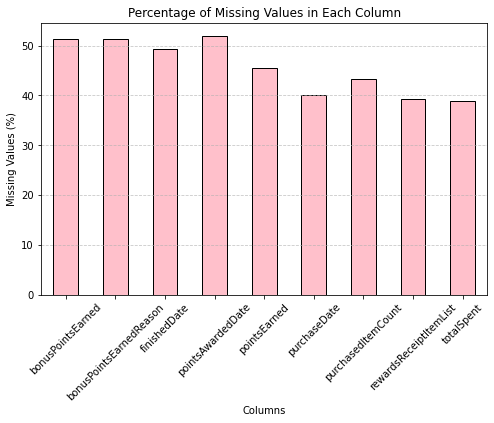

In [17]:
# Check for missing values in receipts, users, brands and receipt_items DataFrames
import matplotlib.pyplot as plt

# Calculate missing values percentage in receipts
missing_percentage = (receipts.isnull().sum() / len(receipts)) * 100

# Filter out columns with no missing values
missing_percentage = missing_percentage[missing_percentage > 0]

# Plot the missing values as a bar chart
plt.figure(figsize=(8, 5))
missing_percentage.plot(kind='bar', color='pink', edgecolor='black')
plt.xlabel("Columns")
plt.ylabel("Missing Values (%)")
plt.title("Percentage of Missing Values in Each Column")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()  

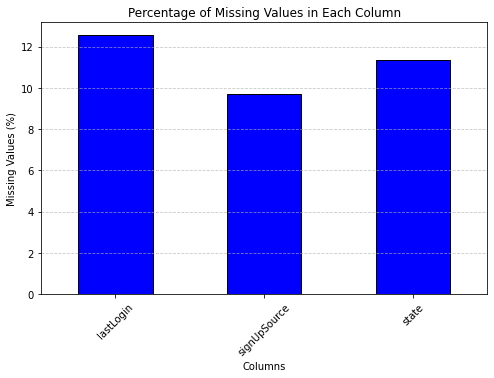

In [18]:
# Calculate missing values percentage in users
missing_percentage = (users.isnull().sum() / len(users)) * 100

# Filter out columns with no missing values
missing_percentage = missing_percentage[missing_percentage > 0]

# Plot the missing values as a bar chart
plt.figure(figsize=(8, 5))
missing_percentage.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel("Columns")
plt.ylabel("Missing Values (%)")
plt.title("Percentage of Missing Values in Each Column")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()  

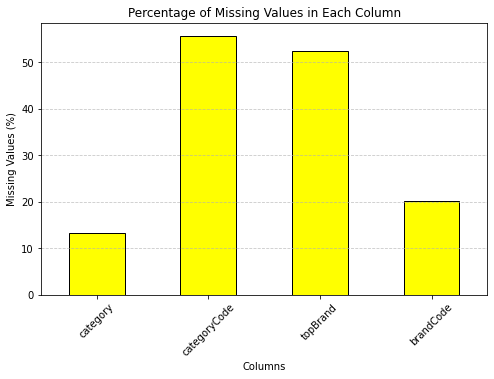

In [19]:
# Calculate missing values percentage in brands
missing_percentage = (brands.isnull().sum() / len(brands)) * 100

# Filter out columns with no missing values
missing_percentage = missing_percentage[missing_percentage > 0]

# Plot the missing values as a bar chart
plt.figure(figsize=(8, 5))
missing_percentage.plot(kind='bar', color='yellow', edgecolor='black')
plt.xlabel("Columns")
plt.ylabel("Missing Values (%)")
plt.title("Percentage of Missing Values in Each Column")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()  

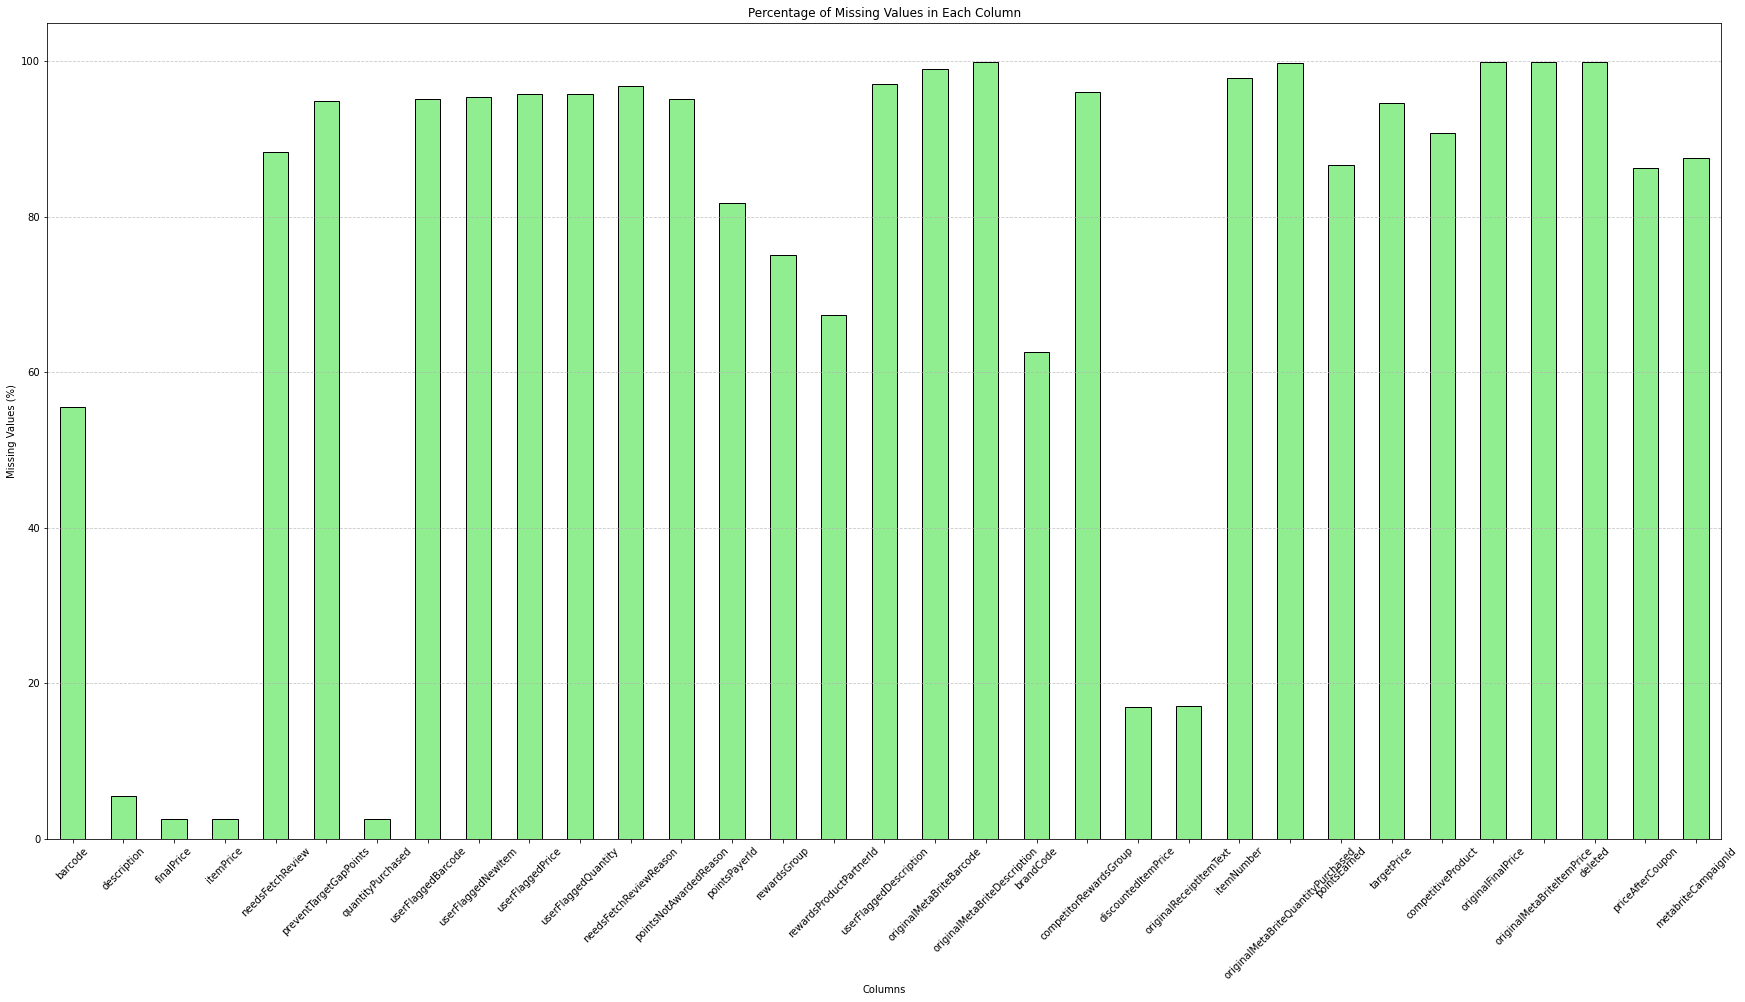

In [20]:
# Calculate missing values percentage in receipt_items
missing_percentage = (receipt_items.isnull().sum() / len(receipt_items)) * 100

# Filter out columns with no missing values
missing_percentage = missing_percentage[missing_percentage > 0]

# Plot the missing values as a bar chart
plt.figure(figsize=(30, 15))
missing_percentage.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel("Columns")
plt.ylabel("Missing Values (%)")
plt.title("Percentage of Missing Values in Each Column")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()  

### 3.2 Check Duplicates

In [21]:
# Check for duplicates in the receipts, users and brands DataFrame
duplicate_receipts = receipts[receipts.duplicated()]
print("Duplicate Receipts:")
print(duplicate_receipts)

duplicate_users = users[users.duplicated()]
print("Duplicate Users:")
print(duplicate_users)

duplicate_brands = brands[brands.duplicated()]
print("Duplicate Brands:")
print(duplicate_brands)


Duplicate Receipts:
Empty DataFrame
Columns: [_id, bonusPointsEarned, bonusPointsEarnedReason, createDate, dateScanned, finishedDate, modifyDate, pointsAwardedDate, pointsEarned, purchaseDate, purchasedItemCount, rewardsReceiptItemList, rewardsReceiptStatus, totalSpent, userId]
Index: []
Duplicate Users:
                          _id  active             createdDate  \
1    5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
3    5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
4    5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
7    5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
9    5ff1e194b6a9d73a3a9f1052    True 2021-01-03 15:24:04.800   
..                        ...     ...                     ...   
489  54943462e4b07e684157a532    True 2014-12-19 14:21:22.381   
490  54943462e4b07e684157a532    True 2014-12-19 14:21:22.381   
491  54943462e4b07e684157a532    True 2014-12-19 14:21:22.381   
492  54943462e4b07e684157a532    True 2014-1

### 3.3 Data Type Issues (May not be comprehensive as it is already been cleaned for SQL queries)
Ans: pointsEarned, totalSpent in receipts table are object, not numerical

In [22]:
# Check data types of columns
print(receipts.dtypes) 
print(users.dtypes)   
print(brands.dtypes)  

_id                                object
bonusPointsEarned                 float64
bonusPointsEarnedReason            object
createDate                 datetime64[ns]
dateScanned                datetime64[ns]
finishedDate               datetime64[ns]
modifyDate                 datetime64[ns]
pointsAwardedDate          datetime64[ns]
pointsEarned                       object
purchaseDate               datetime64[ns]
purchasedItemCount                float64
rewardsReceiptItemList             object
rewardsReceiptStatus               object
totalSpent                         object
userId                             object
dtype: object
_id                     object
active                    bool
createdDate     datetime64[ns]
lastLogin       datetime64[ns]
role                    object
signUpSource            object
state                   object
dtype: object
_id             object
barcode         object
category        object
categoryCode    object
name            object
topBrand  

### 3.4 Outliers

Statistics for totalSpent:
 count     684.000000
mean       77.796857
std       347.110349
min         0.000000
25%         1.000000
50%        18.200000
75%        34.960000
max      4721.950000
Name: totalSpent, dtype: float64


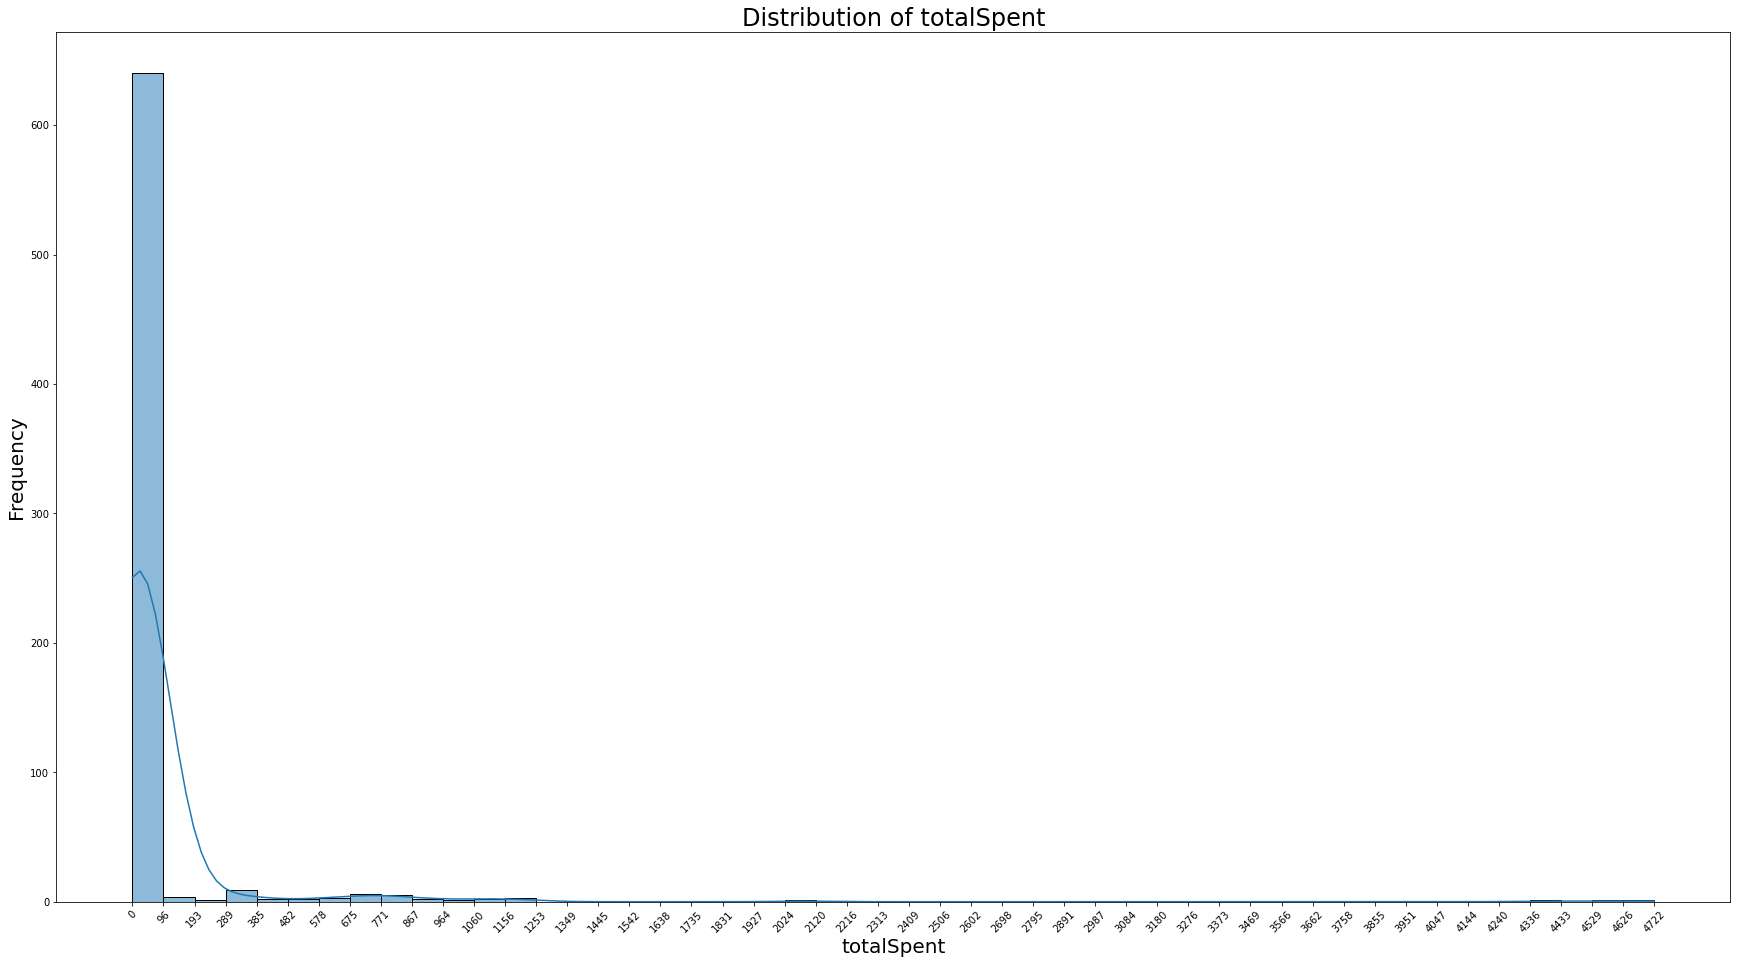

Statistics for purchasedItemCount:
 count    635.00000
mean      14.75748
std       61.13424
min        0.00000
25%        1.00000
50%        2.00000
75%        5.00000
max      689.00000
Name: purchasedItemCount, dtype: float64


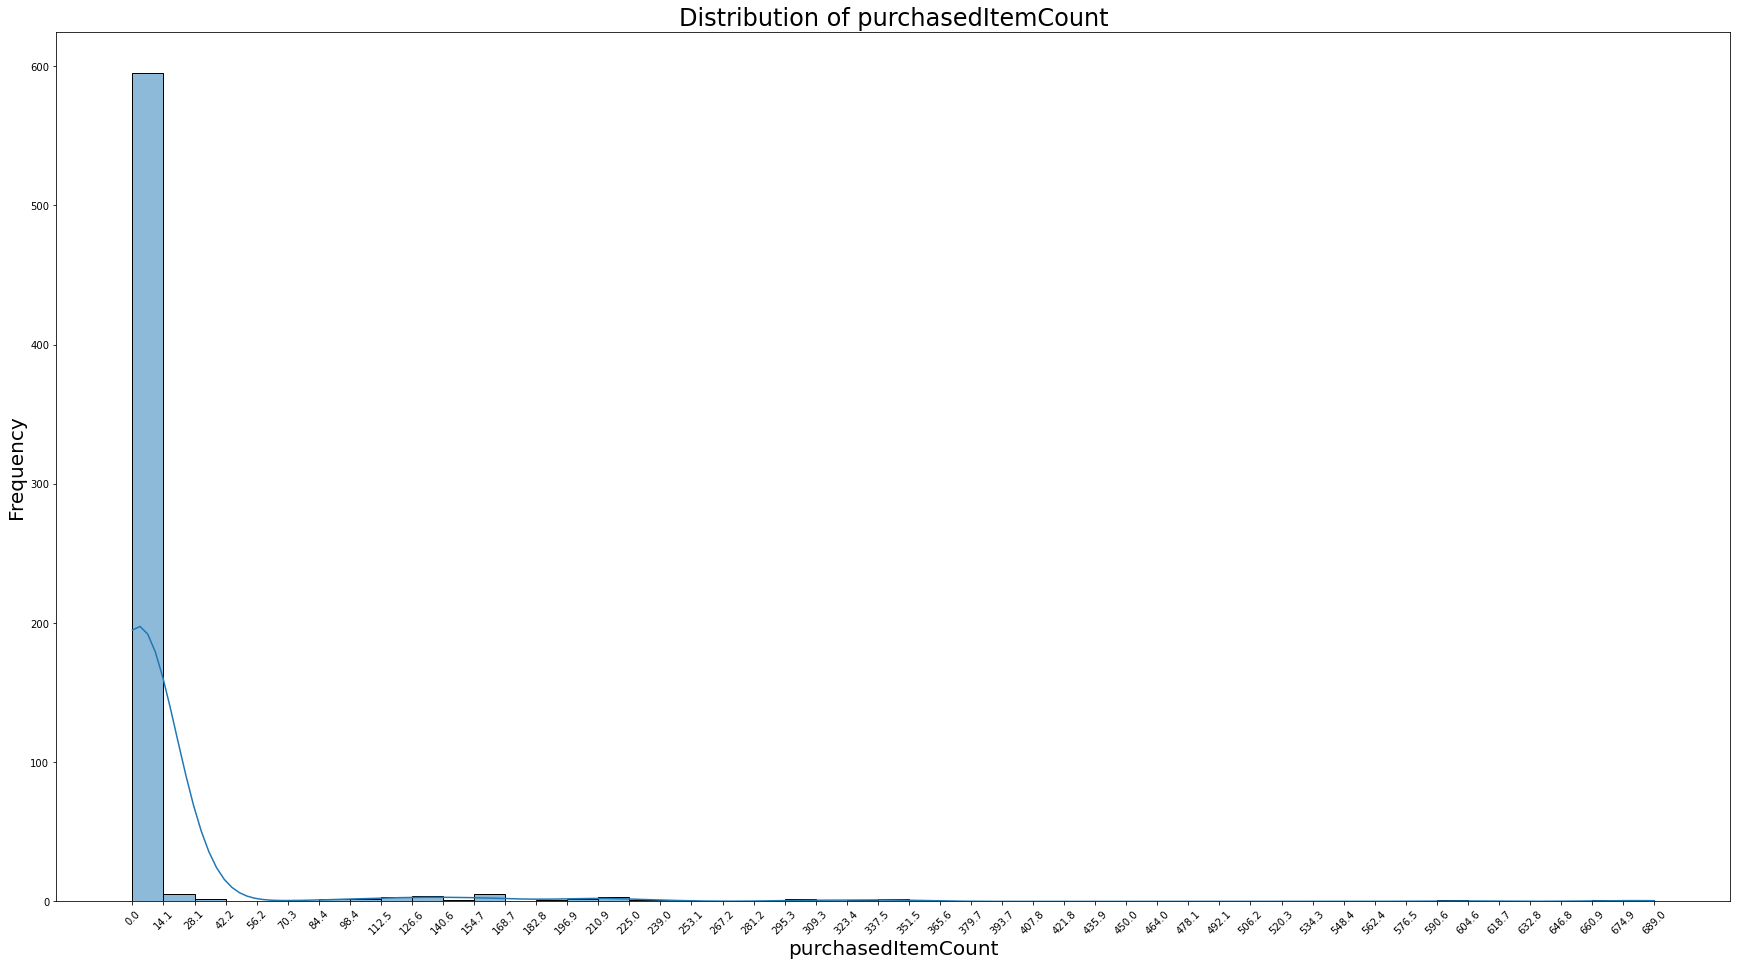

Statistics for pointsEarned:
 count      609.000000
mean       585.962890
std       1357.166947
min          0.000000
25%          5.000000
50%        150.000000
75%        750.000000
max      10199.800000
Name: pointsEarned, dtype: float64


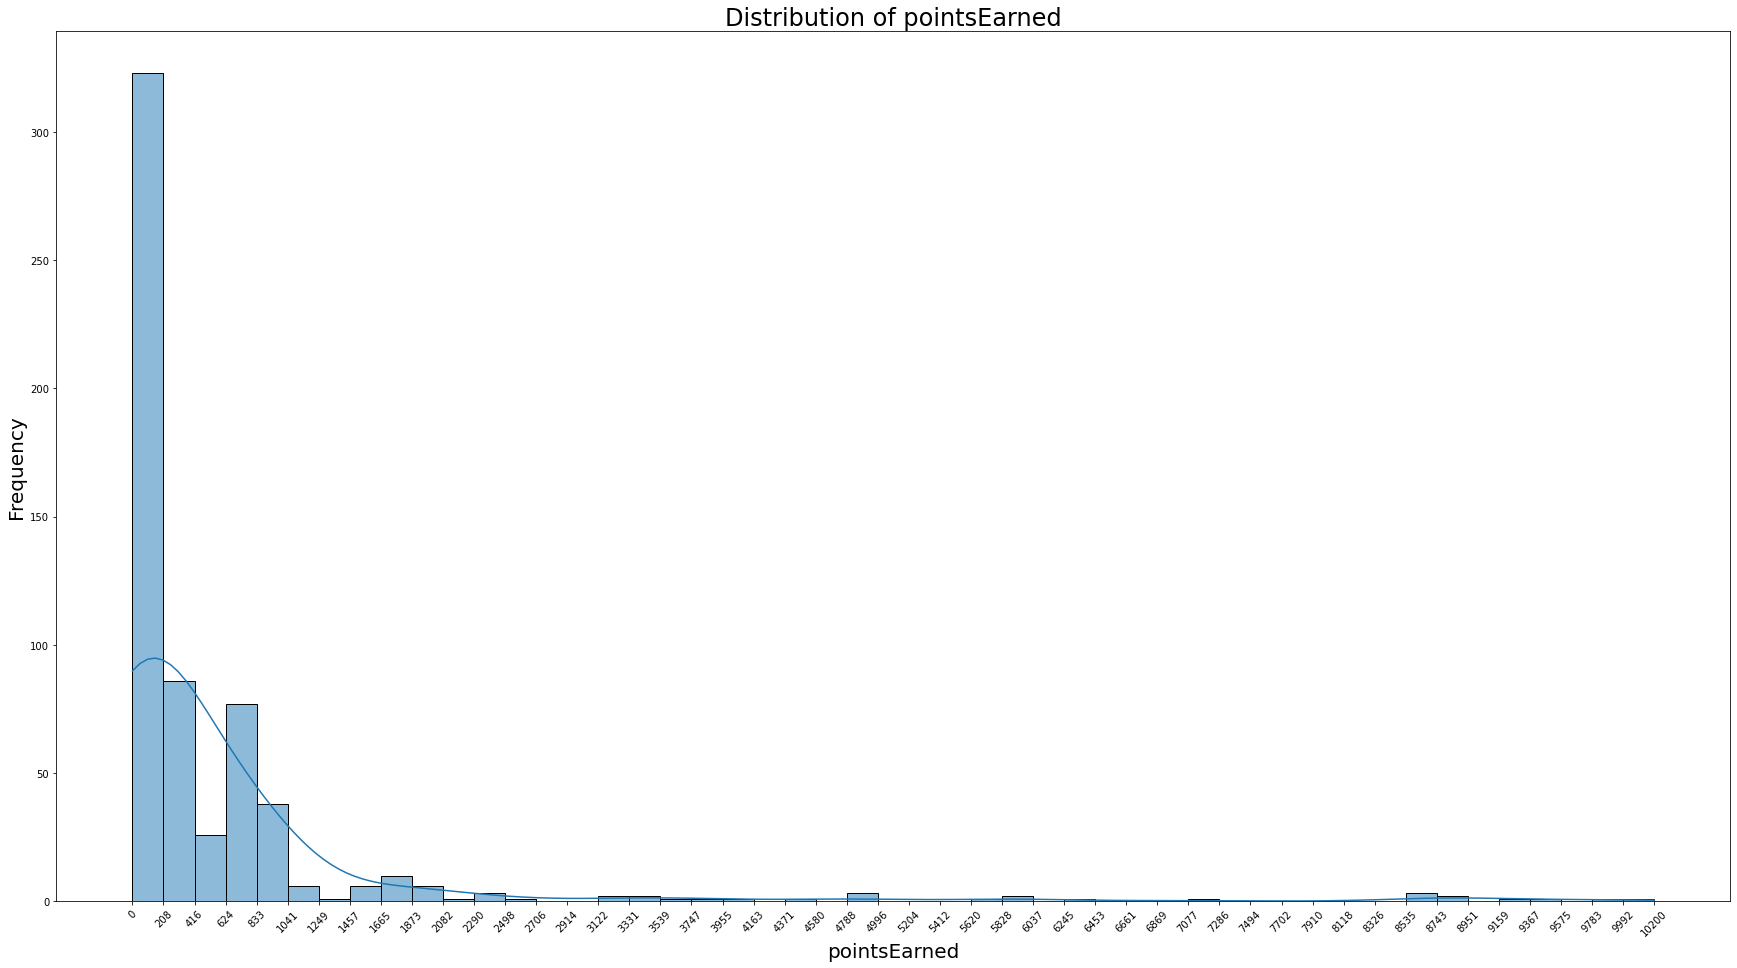

Statistics for bonusPointsEarned:
 count    544.000000
mean     238.893382
std      299.091731
min        5.000000
25%        5.000000
50%       45.000000
75%      500.000000
max      750.000000
Name: bonusPointsEarned, dtype: float64


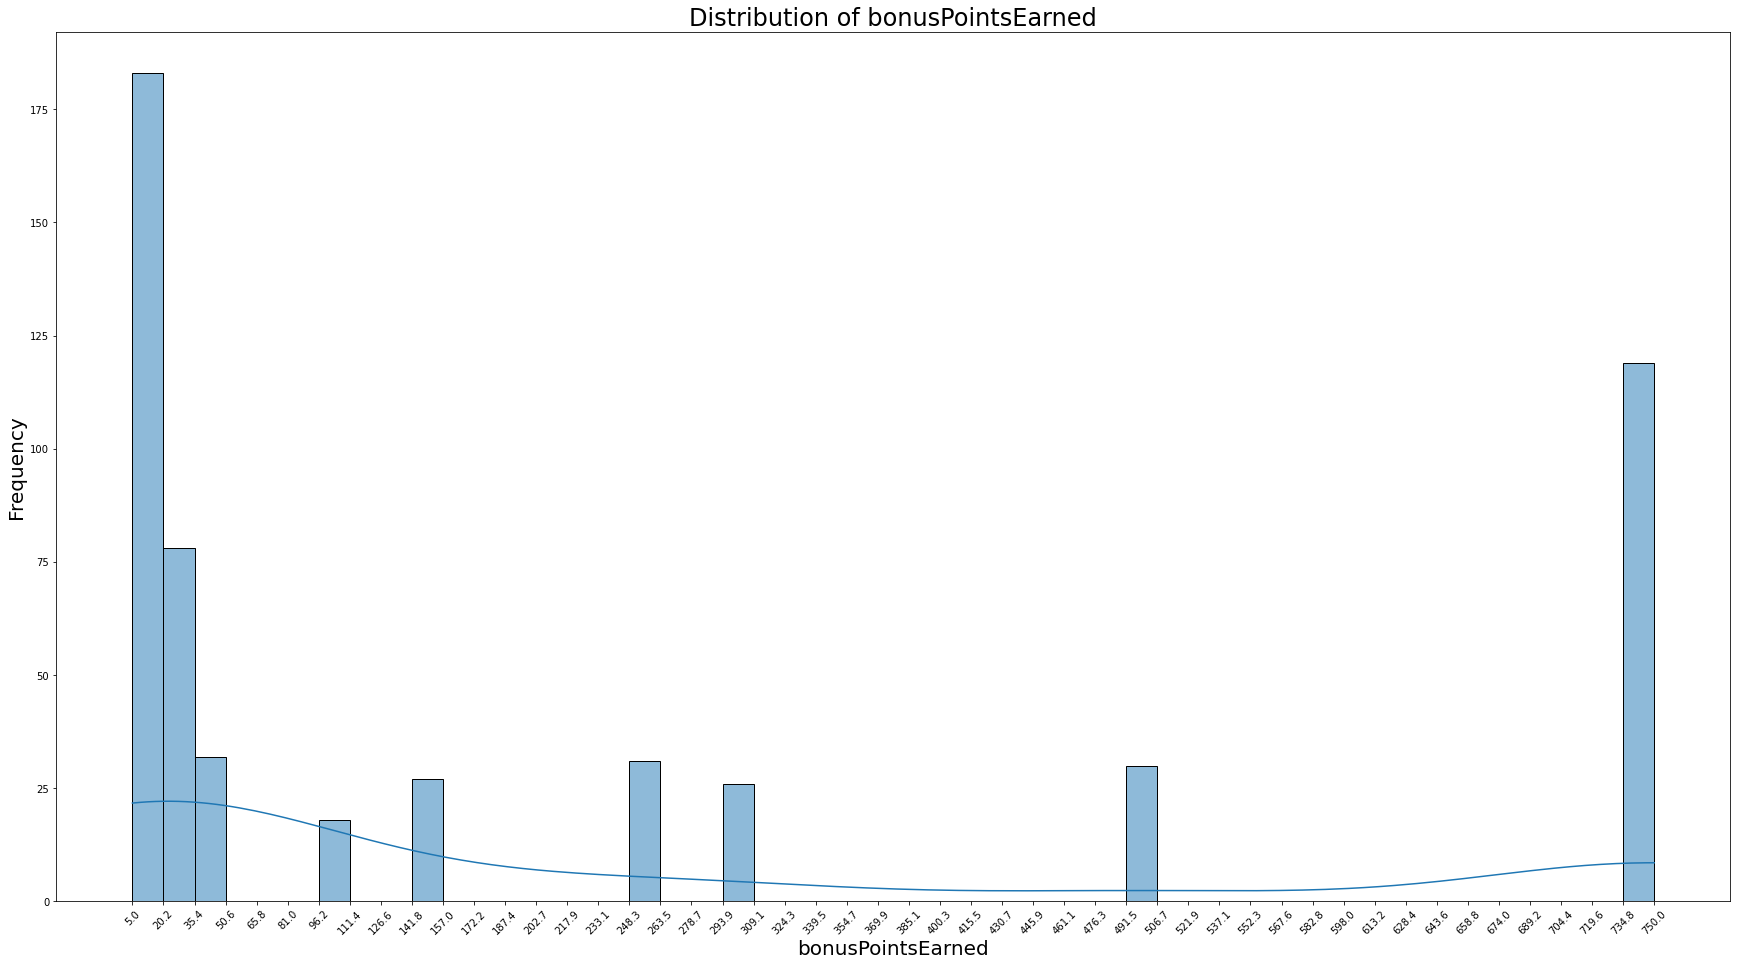

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select numerical columns
numerical_cols = ['pointsEarned', 'bonusPointsEarned', 'purchasedItemCount', 'totalSpent']

# Order columns by number of non-null values
numerical_cols = sorted(numerical_cols, key=lambda col: receipts[col].astype(float).count(), reverse=True)

# Loop through numerical columns and plot distribution
for col in numerical_cols:
    plt.figure(figsize=(30, 16))  
    data = receipts[col].dropna().astype(float)  # Drop NaNs and ensure float type
    
    print(f"Statistics for {col}:\n", data.describe())

    # Determine bin edges dynamically to sort x-axis from small to big values
    bin_size = np.linspace(data.min(), data.max(), num=50)  

    sns.histplot(data, bins=bin_size, kde=True)
    plt.title(f'Distribution of {col}', fontsize=24)
    plt.xlabel(col, fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.xticks(sorted(bin_size), rotation=45)  # Sorted x-axis values
    plt.show()


### 3.5 Temporal Consistency


In [24]:
# Check temporal consistency in receipts DataFrame

# Create date should not be after finished date
print(receipts[receipts['createDate'] > receipts['finishedDate']])  


Empty DataFrame
Columns: [_id, bonusPointsEarned, bonusPointsEarnedReason, createDate, dateScanned, finishedDate, modifyDate, pointsAwardedDate, pointsEarned, purchaseDate, purchasedItemCount, rewardsReceiptItemList, rewardsReceiptStatus, totalSpent, userId]
Index: []


# 4. Email / Slack Messages

Hi Team, 

I wanted to share an update on my review of the data on receipts, users and brands. I’ve discovered some findings, found several issues and wanted to discuss next steps and any questions I have to move forward.

First, I want to share the approach I took to understand the data. I unzipped the file, put into a table structure, and did the exploratory analysis on the data. 

Then, I came across some data quality issues while checking the data.

1. Duplicates in the users data: we need to understand why this is happening when we stored the data. 
2. Missing values: like totalSpent, bonusPointsEarned, brandCode, etc. I wish to understand if there are data relationships and rules for certain fields, such as is a receipt must always have a matching user and brand. Those are key fields that we don't want to miss our information as they are important to understand business performances. 
3. Extreme values, or we call outliers: data showed that someone earned 750 bonus points or spent above 7500. We need to verify if that's true. 

I also believe there is room for optimization and scalability. 
1. Data Formatting: Timestamp Columns are stored in json format that needs additional step every time we extract it. Is this arbitrary or we can implement transformation before we bring the data in. 
2. Database Choices: As the data grows, performance might be affected, especially when making large calculations or combining datasets (e.g., grouping by users or brands). We may consider MangoDB or NoSQL database that natively support Json format. 
3. Query Performance: As more receipts are scanned, queries may slow down. We may wish to introduce materialized views for frequent queries.


Let me know if you have any questions or if there’s anything you’d like to prioritize. I’m happy to go over these findings in more detail.

Best regards, <br/>
Xunge
